Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 5 - Technical Analysis and Building Interactive Dashboards

이 장에서는 Python을 사용한 기술적 분석(TA)의 기초를 다룹니다. 간단히 말해, TA는 과거 시장 데이터(특히 가격과 거래량)를 연구하여 자산 가격의 미래 방향을 예측하고 투자 기회를 식별하는 방법론입니다. 우리는 가장 인기 있는 TA 지표를 계산하는 방법을 보여주며, 특정 Python 라이브러리를 사용하여 다른 지표를 계산하는 방법에 대한 힌트도 제공합니다. 또한 신뢰할 수 있는 금융 데이터 제공업체로부터 미리 계산된 기술 지표를 다운로드하는 방법도 다룹니다. TA의 하위 분야인 캔들스틱 패턴 인식도 간단히 언급합니다. 장의 마지막에서는 정의된 TA 지표를 시각화하고 인터랙티브하게 분석할 수 있는 웹 애플리케이션을 만드는 방법을 시연합니다. 이 애플리케이션을 클라우드에 배포하여 어디서든 누구나 접근할 수 있도록 만드는 과정도 다룹니다. 이 장에서는 다음과 같은 내용을 다룹니다:

1. 가장 인기 있는 기술적 지표 계산하기
2. 기술적 지표 다운로드하기
3. 캔들스틱 패턴 인식하기
4. Streamlit을 사용한 기술적 분석을 위한 인터랙티브 웹 애플리케이션 구축하기
5. 기술적 분석 애플리케이션 배포하기

## 5.1 Calculating the most popular technical indicators

트레이더들이 포지션에 진입하거나 포기할지 결정하기 위해 사용하는 기술적 지표는 수백 가지에 이릅니다. 이 절에서는 TA-Lib 라이브러리를 사용하여 이러한 지표 중 일부를 쉽게 계산하는 방법을 배웁니다. TA-Lib은 이러한 작업에 가장 널리 사용되는 라이브러리입니다. 먼저 몇 가지 선택된 지표에 대한 간략한 소개로 시작하겠습니다.

볼린저 밴드는 특정 자산의 가격과 변동성에 대한 정보를 도출하기 위해 사용되는 통계적 방법입니다. 볼린저 밴드를 얻기 위해서는 주어진 기간(일반적으로 20일)을 사용하여 시계열(가격)의 이동 평균과 표준 편차를 계산해야 합니다. 그 후, 이동 평균 위/아래에 이동 표준 편차의 K배(일반적으로 2배)만큼 떨어진 곳에 상단/하단 밴드를 설정합니다. 밴드의 해석은 매우 간단합니다. 변동성이 증가하면 밴드가 넓어지고, 변동성이 감소하면 밴드가 수축합니다. 밴드에 2배의 표준 편차를 사용하는 기본 설정은 수익률의 정규성에 대한 가우시안 분포에 근거한 (경험적으로는 부정확한) 가정과 연결되어 있습니다. 가우시안 분포 하에서는 2배의 표준 편차를 사용할 때 95%의 수익률이 밴드 내에 들어갈 것으로 예상할 수 있습니다.

상대 강도 지수(RSI)는 자산의 종가를 사용하여 과매도/과매수 상태를 식별하는 지표입니다. 일반적으로 RSI는 14일 기간을 사용하여 계산되며 0에서 100까지의 척도(진동자)로 측정됩니다. 트레이더들은 보통 RSI가 30 이하일 때 자산을 매수하고, 70 이상일 때 매도합니다. 더 극단적인 고/저 레벨(예: 80–20)은 덜 자주 사용되며, 동시에 더 강한 모멘텀을 의미합니다.

마지막으로 고려할 지표는 이동 평균 수렴/확산(MACD)입니다. 이것은 주어진 자산 가격의 두 지수 이동 평균(EMA) 간의 관계를 보여주는 모멘텀 지표로, 가장 일반적으로 26일과 12일 EMA가 사용됩니다. MACD 선은 빠른 EMA(짧은 기간)와 느린 EMA(긴 기간)의 차이입니다. 마지막으로, MACD 신호선을 MACD 선의 9일 EMA로 계산합니다. 트레이더들은 두 선의 교차를 거래 신호로 사용할 수 있습니다. 예를 들어, MACD 선이 신호선을 아래에서 위로 교차할 때 매수 신호로 간주될 수 있습니다. 자연스럽게 대부분의 지표는 단독으로 사용되지 않으며, 트레이더들은 결정을 내리기 전에 여러 신호를 확인합니다. 또한, 모든 지표는 특정 목표에 따라 매개변수를 변경하여 추가로 조정할 수 있습니다. 기술적 지표를 기반으로 한 거래 전략의 백테스팅은 다른 장에서 다룰 예정입니다.

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd 
import yfinance as yf
import talib

2. Download IBM's stock prices from 2020:

라이브러리를 임포트한 후, 2020년의 IBM 주가 데이터를 다운로드했습니다. 

In [4]:
df = yf.download("IBM", 
                 start="2020-01-01", 
                 end="2020-12-31",
                 progress=False,
                 auto_adjust=True)
df

Open        High         Low       Close   Volume
Date                                                               
2019-12-31  101.199641  102.413765  101.100373  102.352669  3951265
2020-01-02  103.085725  103.788240  102.910103  103.406441  3293436
2020-01-03  101.993803  102.978850  101.986168  102.581779  2482890
2020-01-06  101.879248  102.505396  101.711255  102.398499  2537073
2020-01-07  102.085423  103.055193  101.863981  102.467216  3232977
...                ...         ...         ...         ...      ...
2020-12-23   99.555416  100.624266   99.442906   99.571487  2817819
2020-12-24  100.455508  100.535874   99.820631  100.206375  1842111
2020-12-28  100.535886  101.741348  100.021554  100.310867  3781499
2020-12-29  100.736774  100.841248   99.041082   99.491127  3647402
2020-12-30   99.491136  100.334961   99.354512   99.925102  3535794

[253 rows x 5 columns]

3. Calculate and plot the Simple Moving Average:

3단계에서는 SMA 함수를 사용하여 20일 단순 이동 평균을 계산했습니다. 물론, Pandas DataFrame의 롤링 메서드를 사용하여 동일한 지표를 계산할 수도 있었습니다. 

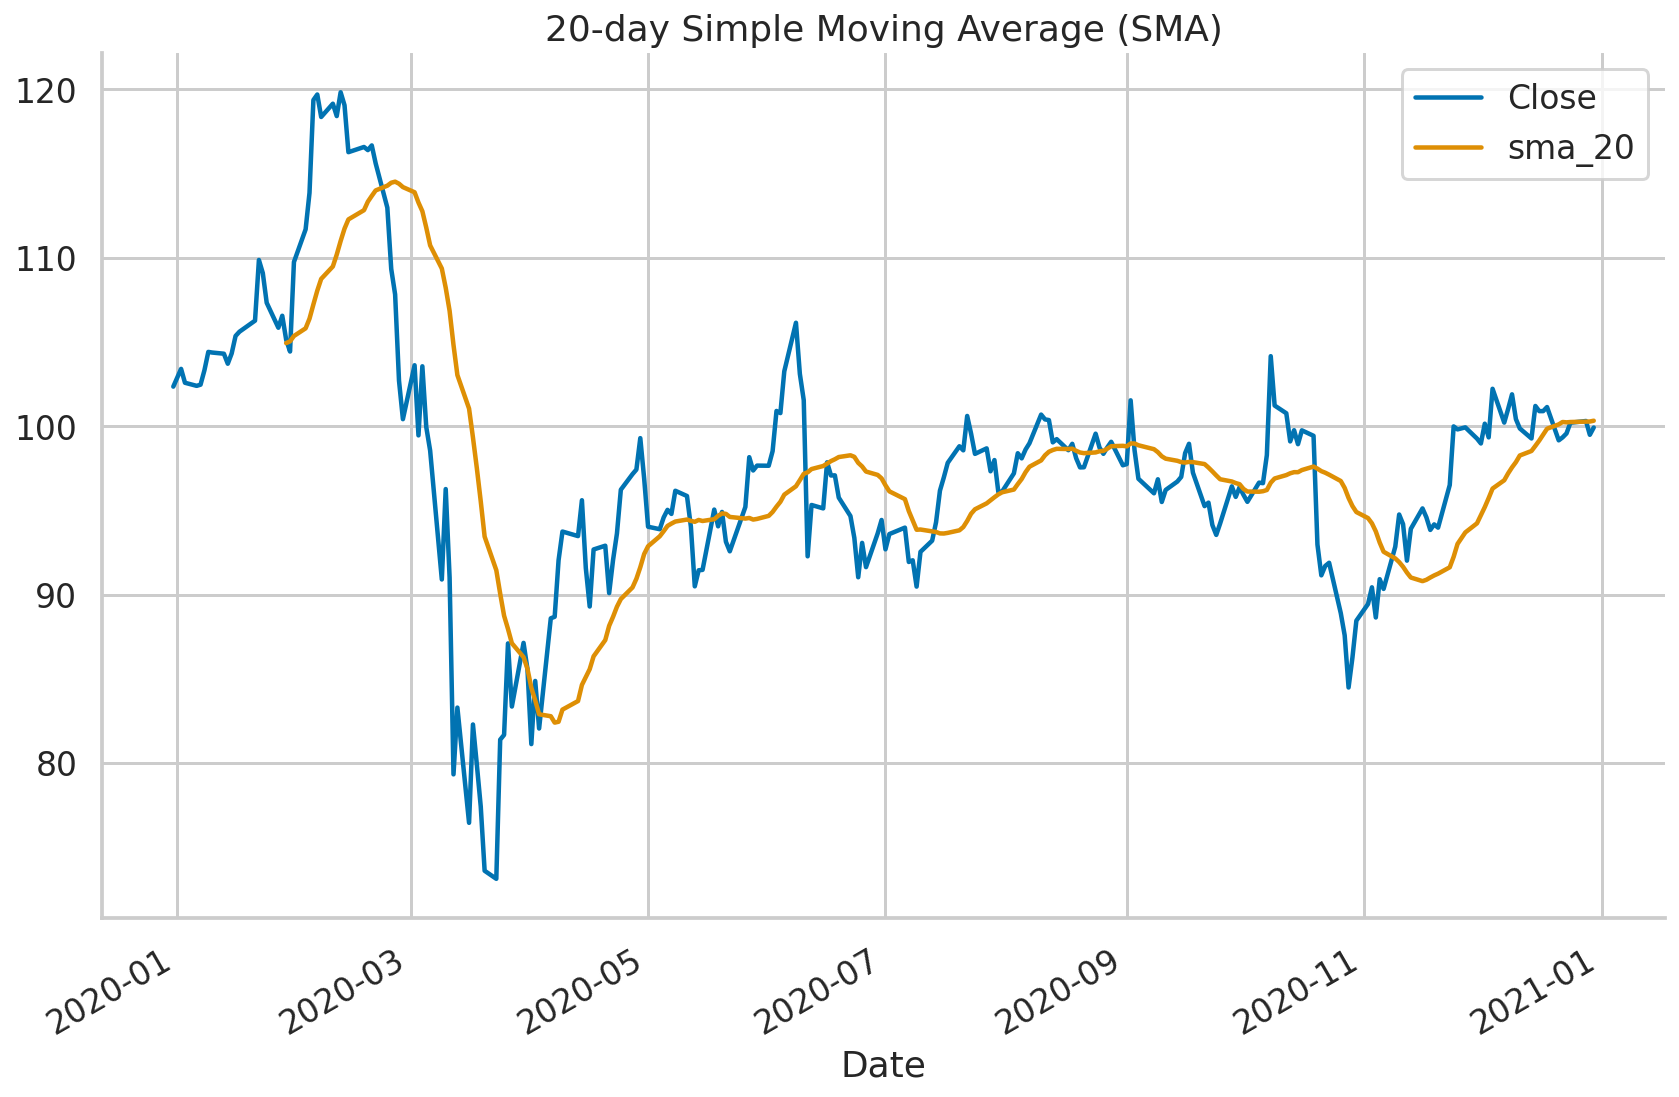

In [5]:
df["sma_20"] = talib.SMA(df["Close"], timeperiod=20)
(
    df[["Close", "sma_20"]]
    .plot(title="20-day Simple Moving Average (SMA)")
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_1", dpi=200)

4. Calculate and plot the Bollinger bands:

4단계에서는 볼린저 밴드를 계산했습니다. BBANDS 함수는 세 가지 객체(상한선, 하한선, 이동 평균)를 반환하며, 이를 DataFrame의 다른 열에 할당했습니다.

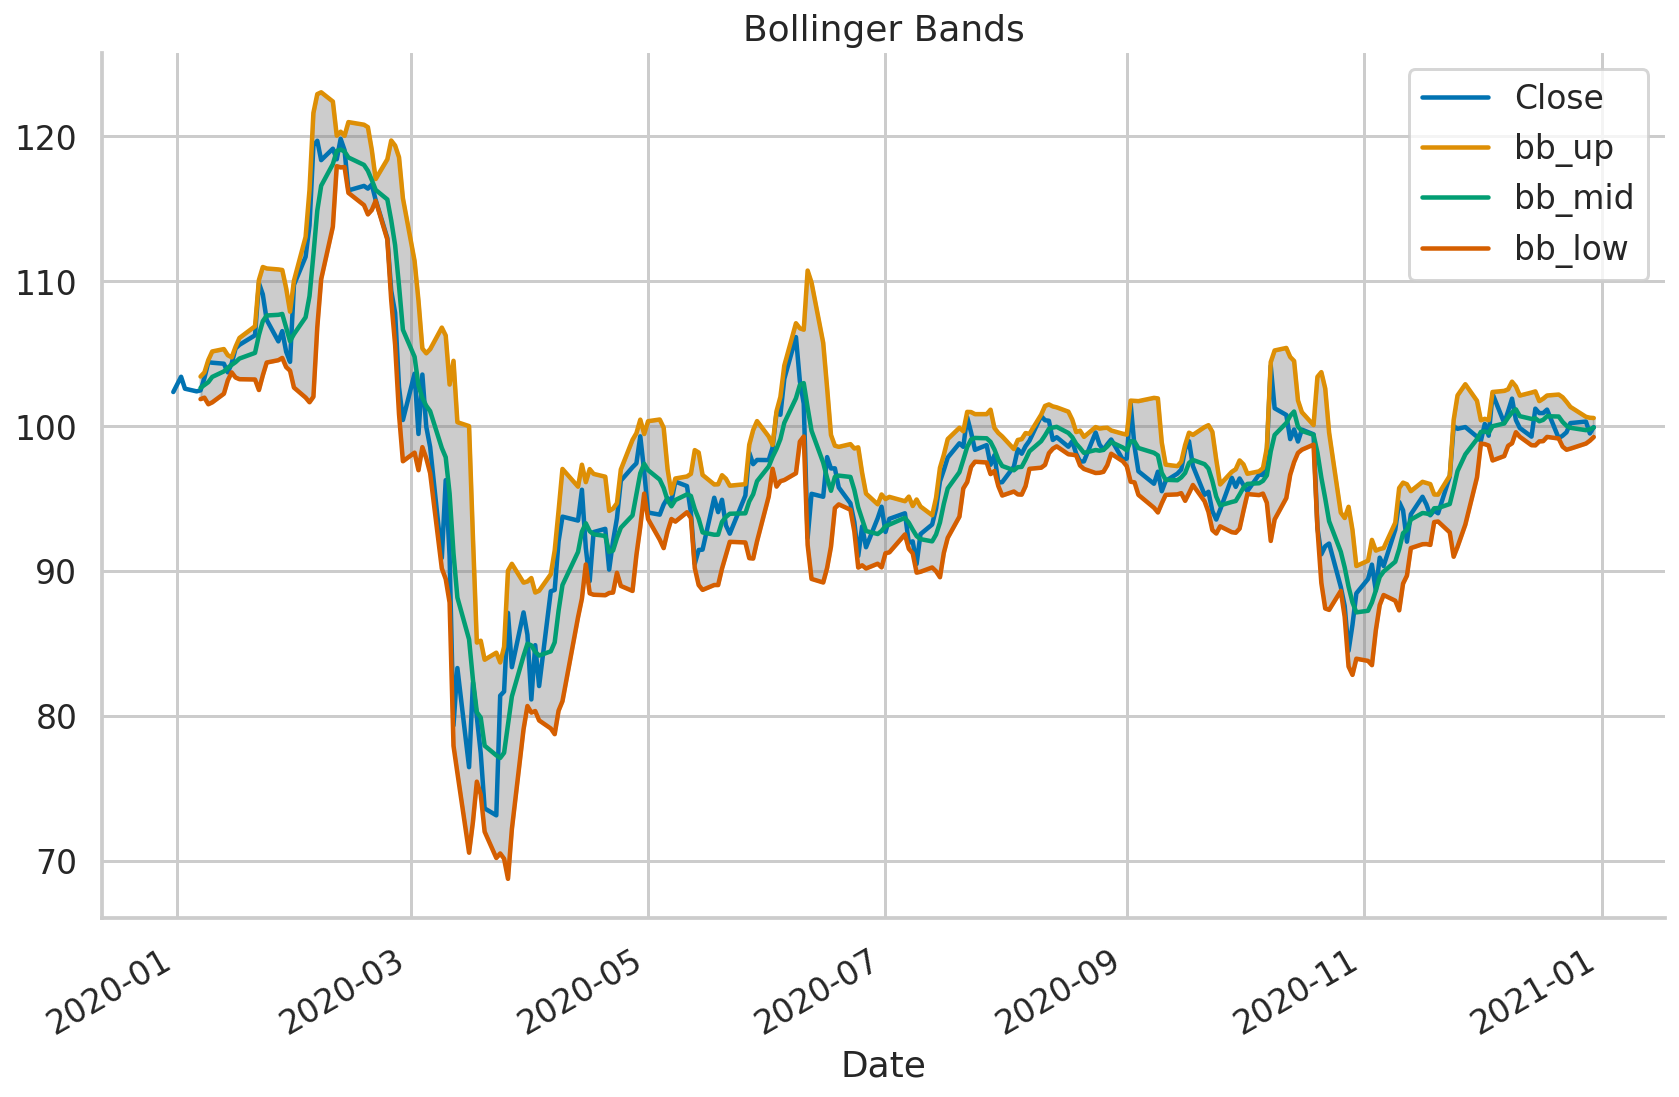

In [6]:
df["bb_up"], df["bb_mid"], df["bb_low"] = talib.BBANDS(df["Close"])

fig, ax = plt.subplots()

(
    df.loc[:, ["Close", "bb_up", "bb_mid", "bb_low"]]
    .plot(ax=ax, title="Bollinger Bands")
)

ax.fill_between(df.index, df["bb_low"], df["bb_up"], 
                color="gray", 
                alpha=.4)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_2", dpi=200)

5. Calculate and plot the RSI:

다음 단계에서는 기본 설정을 사용하여 RSI를 계산했습니다. 이 지표와 함께, 인기 있는 의사결정 임계값을 나타내는 두 개의 수평선(ax.hlines를 사용하여 생성)을 함께 플롯했습니다.

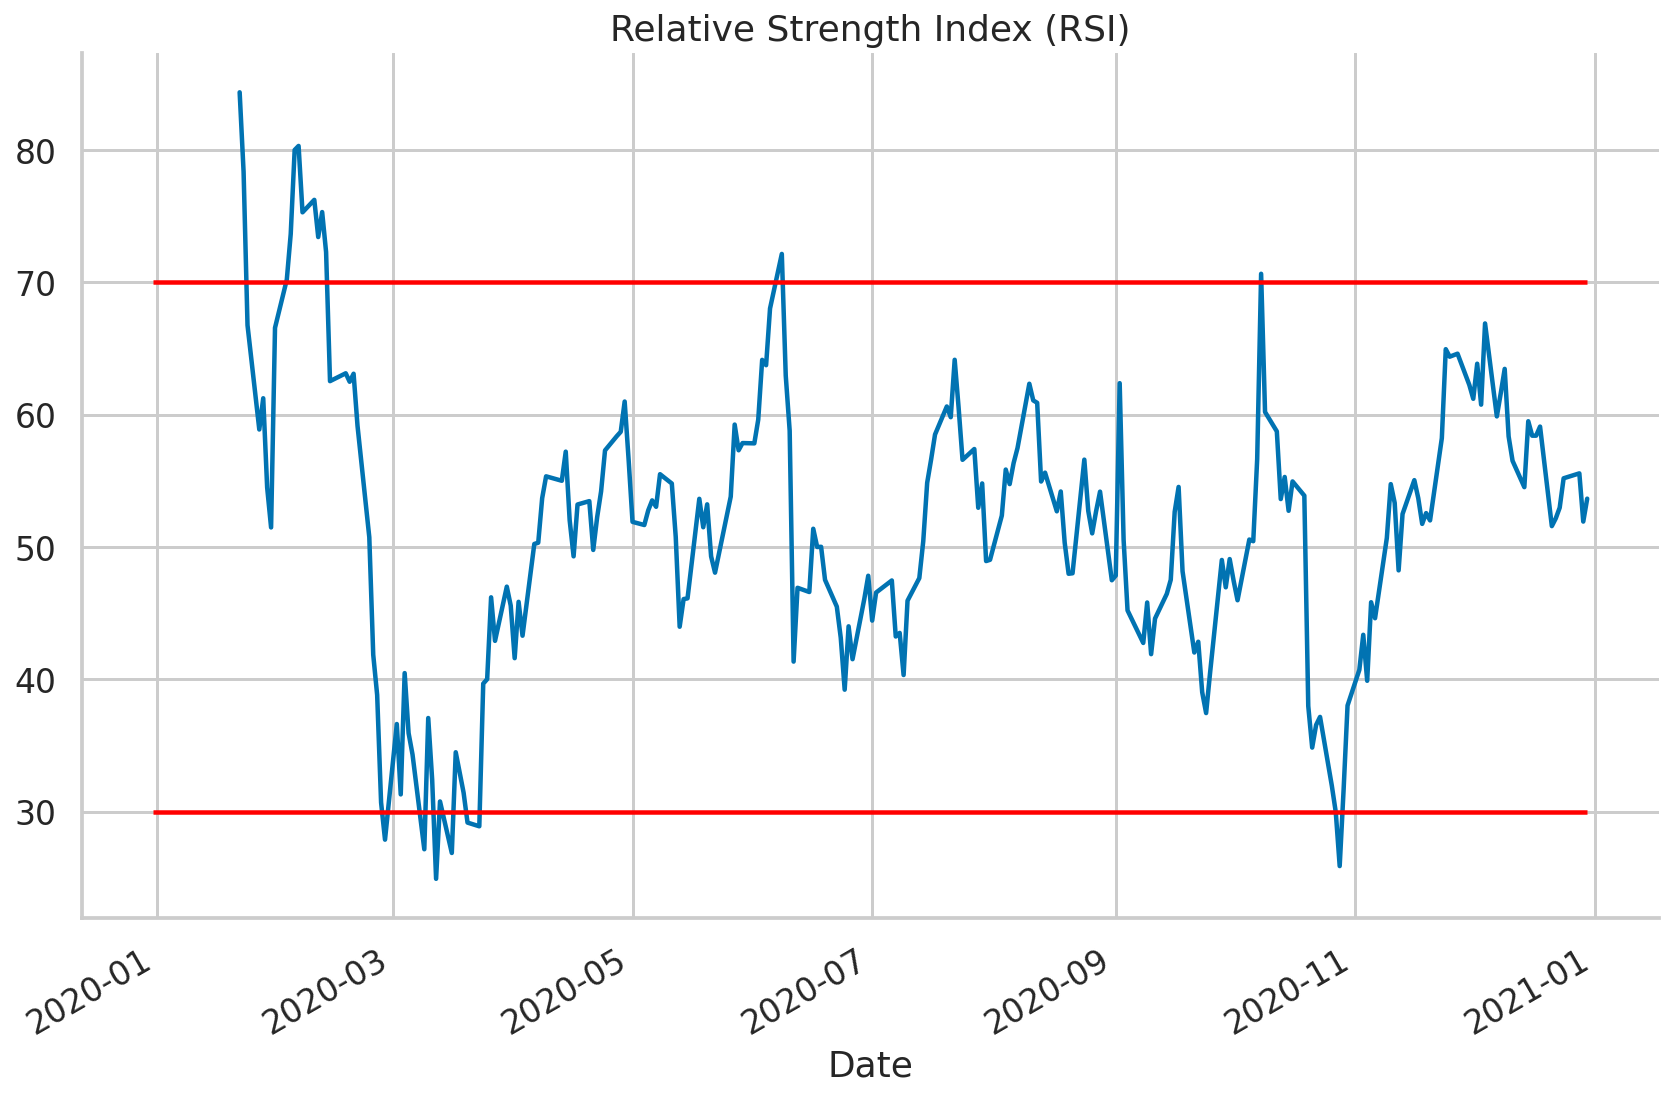

In [7]:
df["rsi"] = talib.RSI(df["Close"])

fig, ax = plt.subplots()
df["rsi"].plot(ax=ax, 
               title="Relative Strength Index (RSI)")
ax.hlines(y=30, 
          xmin=df.index.min(), 
          xmax=df.index.max(), 
          color="red")
ax.hlines(y=70, 
          xmin=df.index.min(), 
          xmax=df.index.max(), 
          color="red")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_3", dpi=200)

6. Calculate and plot the MACD:

마지막 단계에서는 EMA의 기본 기간을 사용하여 MACD를 계산했습니다. MACD 함수 역시 MACD, 신호선, 그리고 MACD 히스토그램이라는 세 가지 객체를 반환했습니다. 이 히스토그램은 첫 번째 두 요소의 차이입니다. 이를 거래 플랫폼에서 흔히 볼 수 있듯이, 별도의 플롯에 표시했습니다.

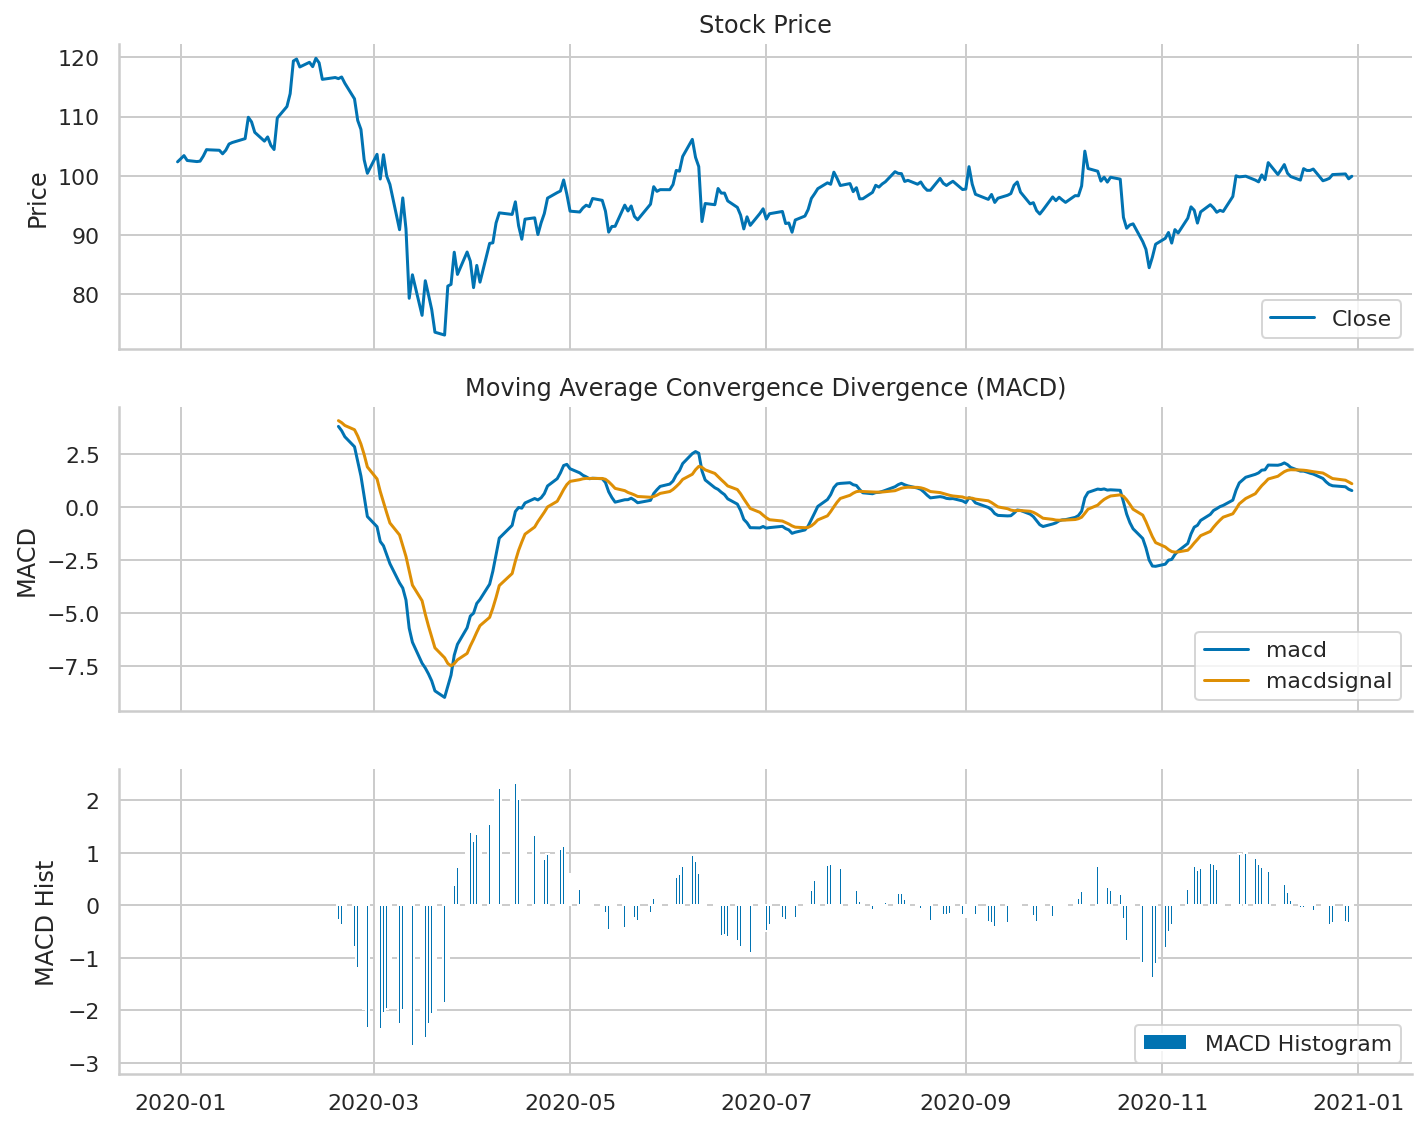

In [15]:
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(
    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
)

with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    # 첫 번째 서브플롯: 주가
    df["Close"].plot(ax=ax[0], title="Stock Price")
    ax[0].set_ylabel("Price")
    ax[0].legend(loc='lower right')  # 주가 레전드를 오른쪽 하단에 위치

    # 두 번째 서브플롯: MACD와 신호선
    df[["macd", "macdsignal"]].plot(ax=ax[1], title="Moving Average Convergence Divergence (MACD)")
    ax[1].set_ylabel("MACD")
    ax[1].legend(loc='lower right')  # MACD 레전드를 오른쪽 하단에 위치

    # 세 번째 서브플롯: 히스토그램
    ax[2].bar(df.index, df["macdhist"].values, label="MACD Histogram")
    ax[2].set_ylabel("MACD Hist")
    ax[2].legend(loc='lower right')  # 히스토그램 레전드를 오른쪽 하단에 위치

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_5_4", dpi=200)
    plt.show()

MACD(이동 평균 수렴 확산, Moving Average Convergence Divergence)는 트레이딩에서 매우 인기 있는 기술적 지표 중 하나로, 자산 가격의 추세와 모멘텀을 평가하는 데 사용됩니다. MACD는 기본적으로 세 가지 요소로 구성됩니다: MACD 라인, 신호선(MACD Signal), 그리고 히스토그램(MACD Histogram)입니다. 각 요소의 의미를 알기 쉽게 설명하겠습니다.

1. **MACD 라인 (`macd`)**
   - **정의:** MACD 라인은 두 개의 지수 이동 평균(EMA)의 차이로 계산됩니다. 일반적으로 12일 EMA에서 26일 EMA를 뺀 값으로 구합니다.
   - **의미:** MACD 라인은 단기적인 추세(12일 EMA)와 장기적인 추세(26일 EMA) 간의 차이를 보여줍니다. 이 값이 양수이면 단기적인 추세가 장기적인 추세보다 강하다는 것을 의미하고, 음수이면 그 반대를 의미합니다.

2. **신호선 (`macdsignal`)**
   - **정의:** 신호선은 MACD 라인의 9일 EMA입니다.
   - **의미:** 신호선은 MACD 라인의 이동 평균이므로, MACD의 값이 변화하는 속도를 부드럽게 조정하여 더 명확한 트렌드 신호를 제공합니다. 트레이더들은 보통 MACD 라인이 신호선을 위로 교차할 때를 매수 신호로, 아래로 교차할 때를 매도 신호로 해석합니다.

3. **히스토그램 (`macdhist`)**
   - **정의:** 히스토그램은 MACD 라인과 신호선 간의 차이를 시각적으로 나타낸 것입니다. 즉, `macdhist = macd - macdsignal`로 계산됩니다.
   - **의미:** 히스토그램은 MACD 라인과 신호선 간의 거리를 보여줍니다. 히스토그램이 양수일 때는 MACD 라인이 신호선 위에 있고, 음수일 때는 MACD 라인이 신호선 아래에 있다는 것을 의미합니다. 히스토그램의 크기가 클수록 두 라인 간의 차이가 크다는 것을 나타내며, 이는 트렌드가 강해지고 있다는 신호일 수 있습니다.

- 예시로 이해하기:
    - **MACD 라인이 신호선 위로 상승할 때**: 이는 자산의 가격이 상승 추세로 전환될 가능성을 의미하며, 트레이더들은 매수 신호로 해석할 수 있습니다.
    - **MACD 라인이 신호선 아래로 하락할 때**: 이는 자산의 가격이 하락 추세로 전환될 가능성을 의미하며, 트레이더들은 매도 신호로 해석할 수 있습니다.
    - **히스토그램의 크기가 커지거나 작아질 때**: 히스토그램이 점점 커진다면 트렌드가 강화되고 있다는 신호일 수 있으며, 작아진다면 트렌드의 힘이 약해지고 있다는 신호일 수 있습니다.

따라서, `macd`, `macdsignal`, `macdhist`는 각각 MACD 지표의 주요 구성 요소이며, 이들을 분석하여 시장의 추세와 모멘텀을 판단하는 데 사용됩니다.

지금까지 우리는 기술적 지표를 계산하고 이를 시각화했습니다. 다음 장에서는 이러한 지표들의 의미와 이를 기반으로 한 거래 전략 구축에 대해 더 많은 시간을 할애할 것입니다.

### There's more

A-Lib은 기술적 지표를 계산하는 데 있어 매우 우수한 라이브러리이며, 사실상 표준으로 자리 잡고 있습니다. 그러나, 최근 인기를 얻고 있는 대체 라이브러리들도 있습니다. 그 중 하나가 ta라는 라이브러리입니다. TA-Lib은 C++ 라이브러리를 래핑한 형태인 반면, ta는 Pandas를 사용하여 작성되어 코드 베이스를 탐색하기 훨씬 쉽습니다. TA-Lib만큼 광범위한 기능을 제공하지는 않지만, ta의 고유한 기능 중 하나는 30개 이상의 지표를 단 한 줄의 코드로 계산할 수 있다는 점입니다. 이는 머신러닝 모델에 사용할 많은 잠재적 기능을 계산해야 하는 상황에서 매우 유용할 수 있습니다. 30개 이상의 기술적 지표를 한 줄의 코드로 계산하려면 다음 단계를 실행하세요.

1. Import the libraries:

In [16]:
from ta import add_all_ta_features

2. Discard the previously calculated indicators and keep only the required columns:

In [17]:
df = df[["Open", "High", "Low", "Close", "Volume"]].copy()

3. Calculate all the technical indicators available in the `ta` library:

In [18]:
df = add_all_ta_features(df, open="Open", high="High", 
                         low="Low", close="Close", 
                         volume="Volume")

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [19]:
df.shape

(253, 88)

In [13]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_nvi', 'volume_vwap', 'volatility_atr',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', '

### See also

아래는 기술적 분석에 유용한 TA-Lib, ta, 및 기타 흥미로운 라이브러리의 저장소 링크입니다:

- https://github.com/mrjbq7/ta-lib — TA-Lib의 GitHub 저장소. 라이브러리 설치에 대한 자세한 내용은 이 소스를 참조하세요.
- https://ta-lib.org/
- https://github.com/bukosabino/ta
- https://github.com/twopirllc/pandas-ta
- https://github.com/peerchemist/finta

## 5.2 Downloading the technical indicators

우리가 이미 1장에서 언급했듯이, 일부 데이터 제공업체는 과거 주가 데이터뿐만 아니라 가장 인기 있는 기술적 지표들도 제공합니다. 이 절에서는 IBM 주식에 대한 RSI 지표를 다운로드하는 방법을 보여드리며, 이전 절에서 TA-Lib 라이브러리를 사용하여 계산한 RSI와 직접 비교할 수 있습니다.

### How to do it...

1. Import the libraries:

라이브러리를 임포트한 후, 사용할 수 있는 기술적 지표를 다운로드하기 위해 TechIndicators 클래스를 인스턴스화했습니다(이 클래스의 메서드를 통해 다운로드할 수 있습니다). 

In [21]:
from alpha_vantage.techindicators import TechIndicators
import os

2. Instantiate the `TechIndicators` class and authenticate:

   - API 키를 제공합니다.
   - 출력을 pandas DataFrame 형태로 받도록 지정합니다.

In [22]:
ta_api = TechIndicators(key=os.environ['ALPHA_VANTAGE_API_KEY'], 
                        output_format="pandas")

3. Download the RSI for IBM's stock:

get_rsi() 메서드를 사용해 IBM 주식의 RSI를 다운로드합니다:
   - 14일을 기준으로 지표를 계산하도록 설정합니다.

In [27]:
rsi_df, rsi_meta = ta_api.get_rsi(symbol="IBM", 
                                  time_period=14)

다운로드된 데이터를 확인합니다:
   - 1999년 11월부터의 데이터가 포함되어 있습니다.
   - 날짜 범위를 지정할 수 없다는 점에 유의해야 합니다.   

In [25]:
rsi_df

RSI
date               
1999-11-19  62.0696
1999-11-22  66.7188
1999-11-23  62.8952
1999-11-24  59.7185
1999-11-26  60.4087
...             ...
2024-08-26  70.2401
2024-08-27  71.3285
2024-08-28  70.3313
2024-08-29  71.0418
2024-08-30  75.6517

[6234 rows x 1 columns]

4. Plot the downloaded RSI:

RSI 선을 플롯합니다.   

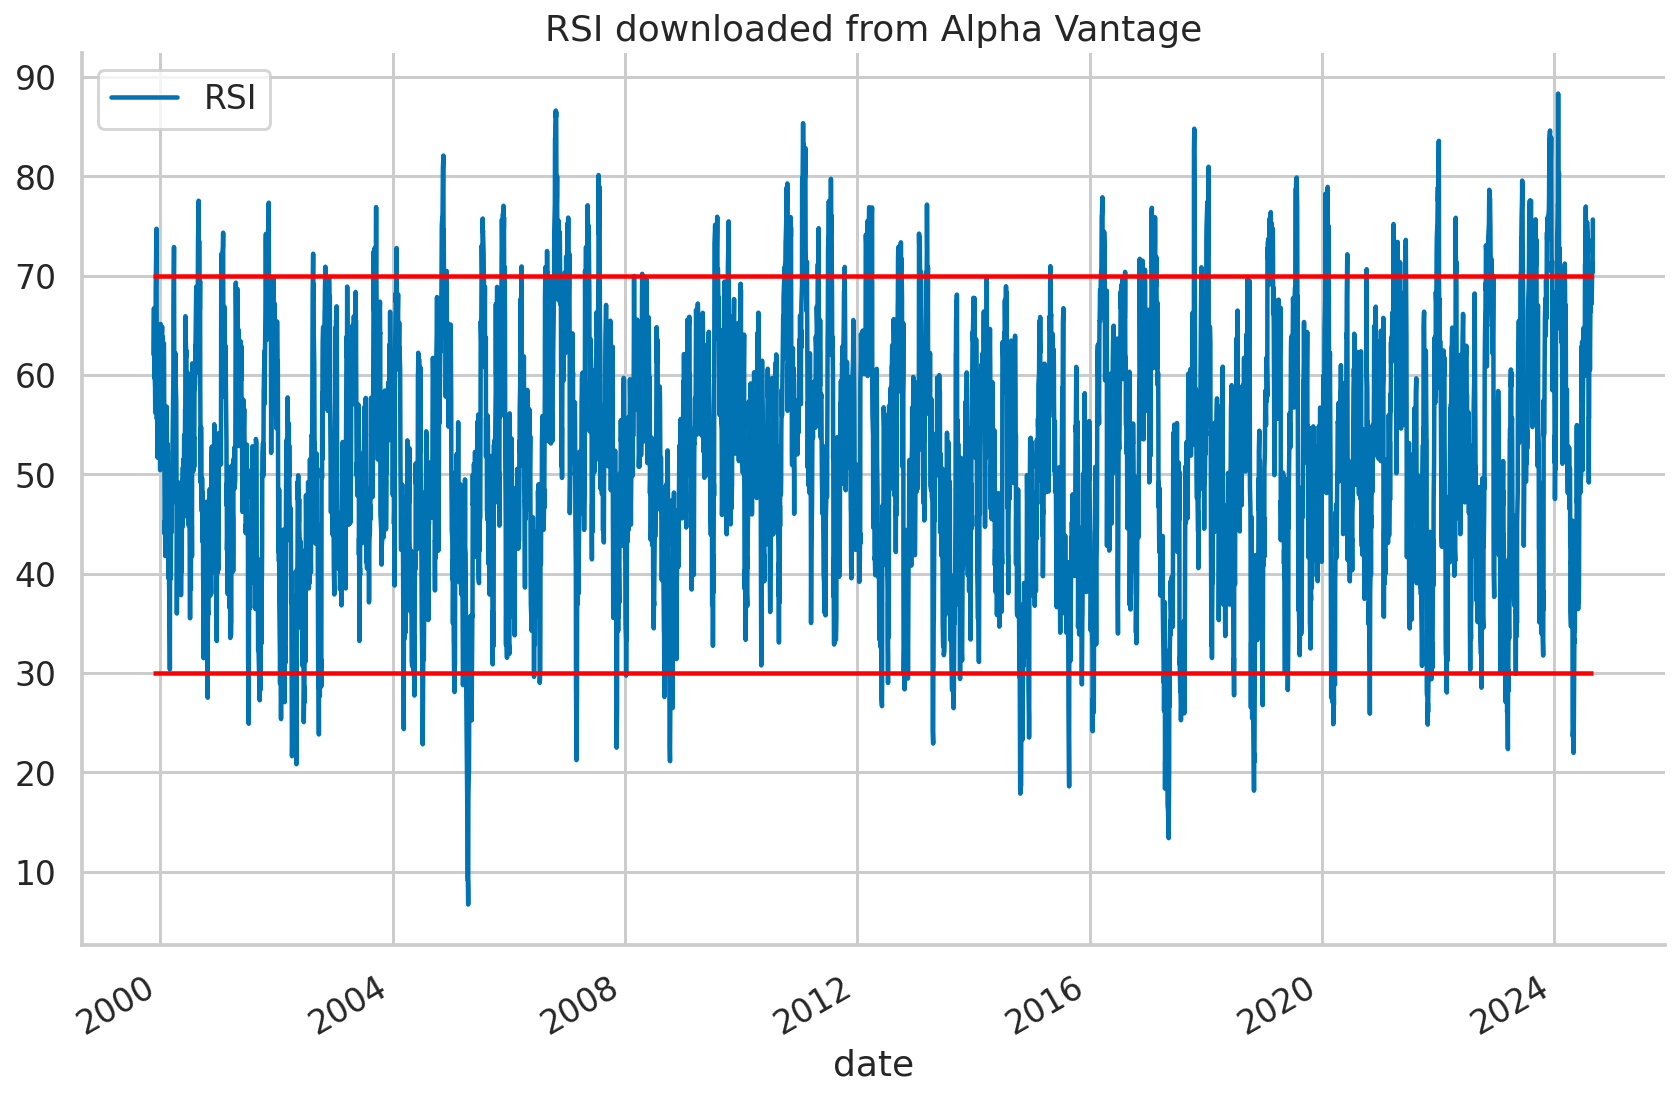

In [24]:
fig, ax = plt.subplots()
rsi_df.plot(ax=ax, 
            title="RSI downloaded from Alpha Vantage")
ax.hlines(y=30, 
          xmin=rsi_df.index.min(), 
          xmax=rsi_df.index.max(), 
          color="red")
ax.hlines(y=70, 
          xmin=rsi_df.index.min(), 
          xmax=rsi_df.index.max(), 
          color="red")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_5", dpi=200)

5. Explore the metadata object:

요청의 메타데이터를 확인합니다:
   - RSI의 세부 정보가 포함되어 있습니다.

In [26]:
rsi_meta

{'1: Symbol': 'IBM',
 '2: Indicator': 'Relative Strength Index (RSI)',
 '3: Last Refreshed': '2024-08-30',
 '4: Interval': 'daily',
 '5: Time Period': 14,
 '6: Series Type': 'close',
 '7: Time Zone': 'US/Eastern Time'}

**주의사항**

- 데이터 제공업체의 가격 정책을 확인해야 합니다. 
   - Alpha Vantage의 경우 RSI는 무료이지만 MACD는 유료입니다.

- 원하는 날짜 범위를 지정할 수 없다는 제한이 있습니다.

이러한 과정을 통해 기술 지표를 다운로드하고 분석에 활용할 수 있습니다. 데이터 제공 정책과 제한사항을 잘 파악하고 사용하는 것이 중요합니다.

### There's more

1. Import the libraries:

In [28]:
import intrinio_sdk as intrinio
import pandas as pd

2. Authenticate using the personal API key and select the API:

In [29]:
intrinio.ApiClient().set_api_key(os.environ['INTRINIO_API_KEY']) 
security_api = intrinio.SecurityApi()

3. Request the MACD for IBM's stock from 2020:

In [30]:
r = security_api.get_security_price_technicals_macd(
    identifier="IBM", 
    fast_period=12, 
    slow_period=26, 
    signal_period=9, 
    price_key="close", 
    start_date="2020-01-01", 
    end_date="2020-12-31",
    page_size=500
)

ApiException: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 02 Sep 2024 00:18:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '104', 'Connection': 'keep-alive', 'Vary': 'Origin,Accept-Encoding'})
HTTP response body: {"human":"No active subscription(s).","message":"An active subscription is required to view this data."}


4. Convert the request's output into a `pandas` DataFrame:

In [48]:
macd_df = (
    pd.DataFrame(r.technicals_dict)
    .sort_values("date_time")
    .set_index("date_time")
)
macd_df.index = pd.to_datetime(macd_df.index).date
macd_df

macd_histogram  macd_line  signal_line
2020-01-02        0.101039  -0.027359    -0.128399
2020-01-03        0.069252  -0.041833    -0.111086
2020-01-06        0.031395  -0.071842    -0.103237
2020-01-07        0.012705  -0.087355    -0.100061
2020-01-08        0.072713  -0.009169    -0.081882
...                    ...        ...          ...
2020-12-24       -0.374587   1.123076     1.497662
2020-12-28       -0.340861   1.071586     1.412447
2020-12-29       -0.379825   0.937666     1.317491
2020-12-30       -0.361885   0.865134     1.227020
2020-12-31       -0.244578   0.921297     1.165875

[253 rows x 3 columns]

5. Plot the MACD:

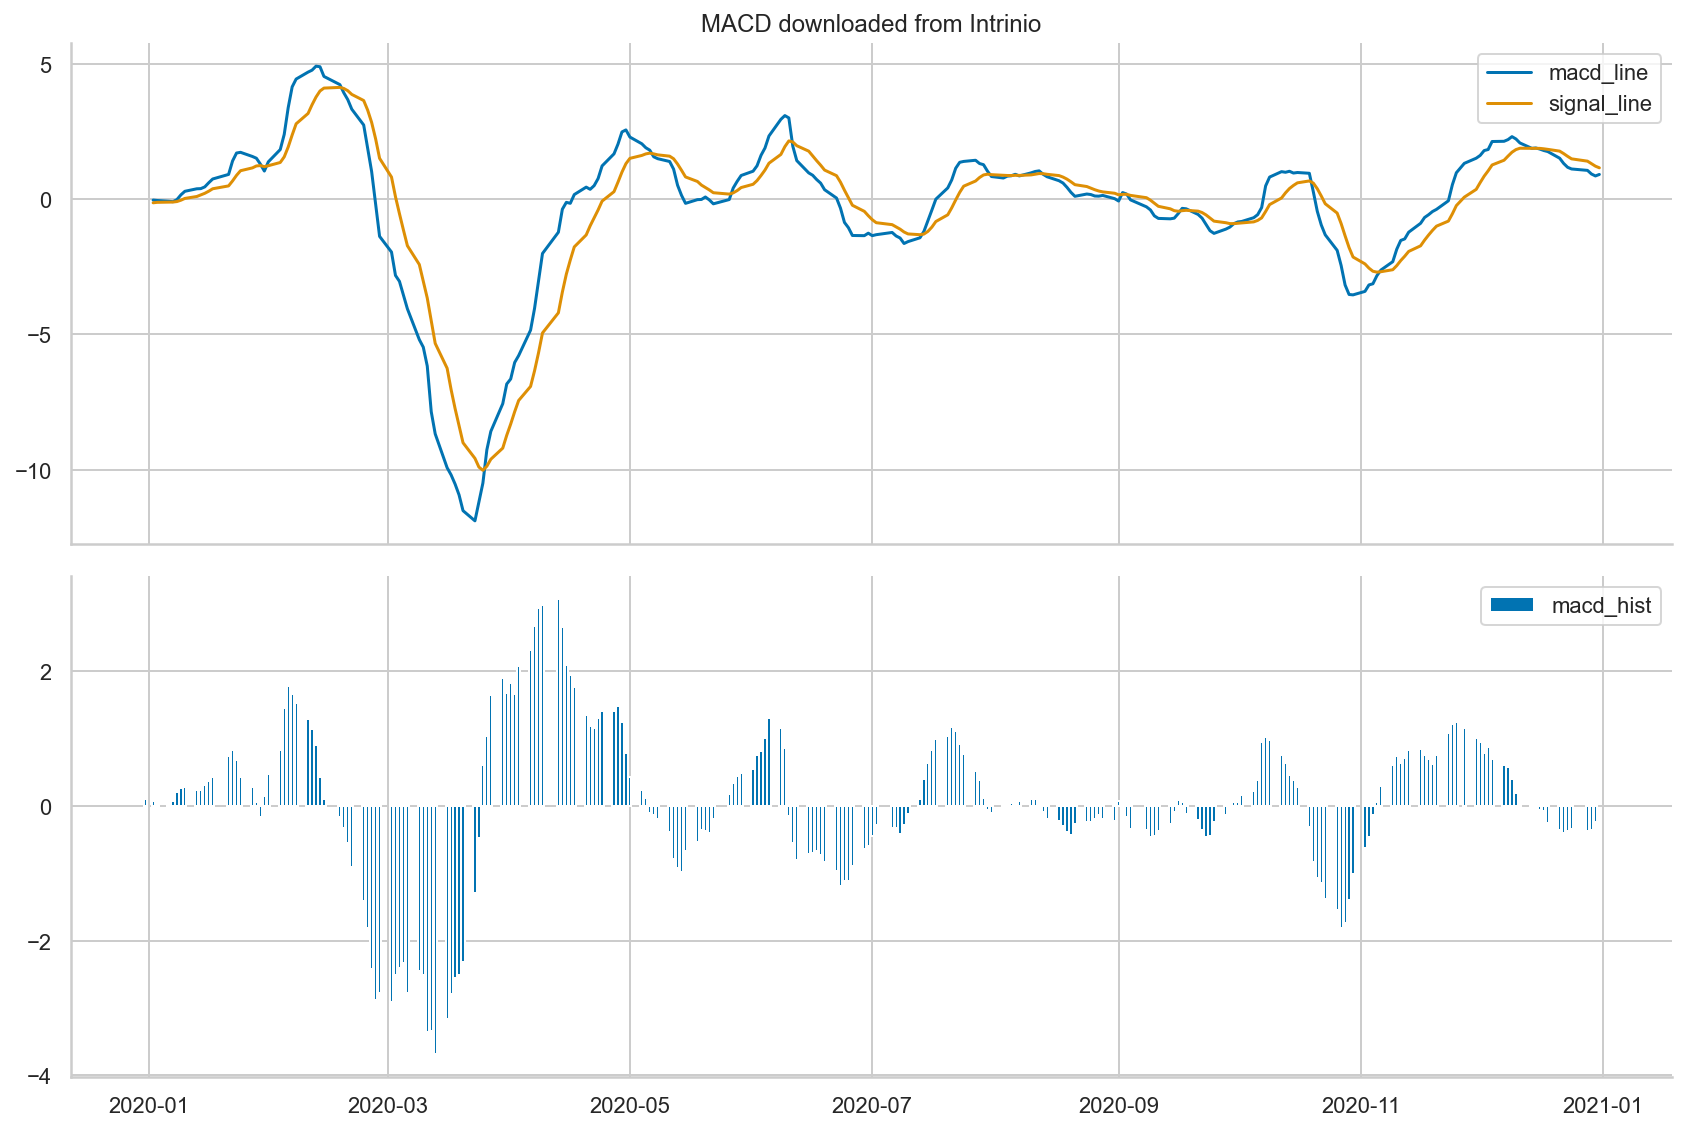

In [51]:
with sns.plotting_context("notebook"):
    
    fig, ax = plt.subplots(2, 1, sharex=True)

    (
        macd_df[["macd_line", "signal_line"]]
        .plot(ax=ax[0], 
              title="MACD downloaded from Intrinio")
    )
    ax[1].bar(df.index, macd_df["macd_histogram"].values, 
              label="macd_hist")
    ax[1].legend()

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_5_6", dpi=200)

## 5.3 Recognizing candlestick patterns

**캔들스틱 패턴 인식의 주요 특징**

- 수백 가지의 캔들스틱 패턴이 가격 방향과 모멘텀을 결정하는 데 사용됩니다.
- 패턴은 주어진 차트(일중, 일간, 주간 등)의 한계 내에서만 유의미합니다.
- 패턴의 예측력은 완성 후 3-5개 봉 이후 빠르게 감소합니다.
- 현대 전자 거래 환경에서는 일부 패턴이 신뢰성 있게 작동하지 않을 수 있습니다.
- 일부 큰 시장 참여자들은 가짜 패턴을 만들어 다른 참여자들을 유인할 수 있습니다.

### How to do it...

1. Import the libraries:

In [62]:
import pandas as pd 
import yfinance as yf
import talib
import mplfinance as mpf

2. Download Bitcoin's hourly prices from the last 3 months:

In [63]:
df = yf.download("BTC-USD", 
                 period="9mo",
                 interval="1h",
                 progress=False)
df

Open          High           Low  \
2023-12-02 09:00:00+00:00  38729.167969  38800.339844  38727.199219   
2023-12-02 10:00:00+00:00  38794.273438  38801.007812  38761.761719   
2023-12-02 11:00:00+00:00  38763.945312  38763.945312  38725.250000   
2023-12-02 12:00:00+00:00  38755.320312  38803.234375  38749.449219   
2023-12-02 13:00:00+00:00  38793.363281  38850.261719  38783.367188   
...                                 ...           ...           ...   
2024-09-02 06:00:00+00:00  57793.335938  57870.117188  57680.675781   
2024-09-02 07:00:00+00:00  57683.976562  57790.773438  57404.035156   
2024-09-02 08:00:00+00:00  57534.312500  58210.746094  57534.312500   
2024-09-02 09:00:00+00:00  58071.609375  58118.246094  57925.832031   
2024-09-02 09:45:00+00:00  58048.500000  58048.500000  58048.500000   

                                  Close     Adj Close      Volume  
2023-12-02 09:00:00+00:00  38799.718750  38799.718750           0  
2023-12-02 10:00:00+00:00  38761.761719  38761.761719           0  
2023-12-02 11:00:00+00:00  38760.949219  38760.949219           0  
2023-12-02 12:00:00+00:00  38782.546875  38782.546875           0  
2023-12-02 13:00:00+00:00  38818.957031  38818.957031           0  
...                                 ...           ...         ...  
2024-09-02 06:00:00+00:00  57683.933594  57683.933594           0  
2024-09-02 07:00:00+00:00  57530.320312  57530.320312    67858432  
2024-09-02 08:00:00+00:00  58092.363281  58092.363281  1139023872  
2024-09-02 09:00:00+00:00  58075.179688  58075.179688   269754368  
2024-09-02 09:45:00+00:00  58048.500000  58048.500000           0  

[6602 rows x 6 columns]

3. Identify the "Three Line Strike" pattern:

**Three Line Strike 패턴**

- 연속 패턴에 속합니다.
- 약세 변형은 전반적인 하락 추세에서 나타납니다.
- 3개의 봉으로 구성되며, 각 봉의 저가가 이전 봉보다 낮습니다.
- 4번째 봉은 3번째 봉의 저가 또는 그 이하에서 시작하지만, 강하게 반전되어 첫 번째 봉의 고가 위에서 마감됩니다.

In [64]:
df["3_line_strike"] = talib.CDL3LINESTRIKE(
    df["Open"], df["High"], df["Low"], df["Close"]
)

4. Locate and plot the bearish pattern:

In [65]:
df[df["3_line_strike"] == -100].head().round(2)

Open      High       Low     Close  Adj Close  \
2023-12-22 01:00:00+00:00  43847.37  44236.46  43847.37  44133.52   44133.52   
2024-02-06 07:00:00+00:00  42731.52  42849.98  42720.71  42849.98   42849.98   
2024-02-10 11:00:00+00:00  46926.74  47217.56  46913.86  47209.73   47209.73   
2024-03-23 11:00:00+00:00  64329.33  64623.18  64265.14  64623.18   64623.18   
2024-03-31 00:00:00+00:00  69647.74  69975.79  69647.74  69896.41   69896.41   

                              Volume  3_line_strike  
2023-12-22 01:00:00+00:00  404320256           -100  
2024-02-06 07:00:00+00:00          0           -100  
2024-02-10 11:00:00+00:00          0           -100  
2024-03-23 11:00:00+00:00          0           -100  
2024-03-31 00:00:00+00:00  147933184           -100

In [66]:
df

Open          High           Low  \
2023-12-02 09:00:00+00:00  38729.167969  38800.339844  38727.199219   
2023-12-02 10:00:00+00:00  38794.273438  38801.007812  38761.761719   
2023-12-02 11:00:00+00:00  38763.945312  38763.945312  38725.250000   
2023-12-02 12:00:00+00:00  38755.320312  38803.234375  38749.449219   
2023-12-02 13:00:00+00:00  38793.363281  38850.261719  38783.367188   
...                                 ...           ...           ...   
2024-09-02 06:00:00+00:00  57793.335938  57870.117188  57680.675781   
2024-09-02 07:00:00+00:00  57683.976562  57790.773438  57404.035156   
2024-09-02 08:00:00+00:00  57534.312500  58210.746094  57534.312500   
2024-09-02 09:00:00+00:00  58071.609375  58118.246094  57925.832031   
2024-09-02 09:45:00+00:00  58048.500000  58048.500000  58048.500000   

                                  Close     Adj Close      Volume  \
2023-12-02 09:00:00+00:00  38799.718750  38799.718750           0   
2023-12-02 10:00:00+00:00  38761.761719  38761.761719           0   
2023-12-02 11:00:00+00:00  38760.949219  38760.949219           0   
2023-12-02 12:00:00+00:00  38782.546875  38782.546875           0   
2023-12-02 13:00:00+00:00  38818.957031  38818.957031           0   
...                                 ...           ...         ...   
2024-09-02 06:00:00+00:00  57683.933594  57683.933594           0   
2024-09-02 07:00:00+00:00  57530.320312  57530.320312    67858432   
2024-09-02 08:00:00+00:00  58092.363281  58092.363281  1139023872   
2024-09-02 09:00:00+00:00  58075.179688  58075.179688   269754368   
2024-09-02 09:45:00+00:00  58048.500000  58048.500000           0   

                           3_line_strike  
2023-12-02 09:00:00+00:00              0  
2023-12-02 10:00:00+00:00              0  
2023-12-02 11:00:00+00:00              0  
2023-12-02 12:00:00+00:00              0  
2023-12-02 13:00:00+00:00              0  
...                                  ...  
2024-09-02 06:00:00+00:00              0  
2024-09-02 07:00:00+00:00              0  
2024-09-02 08:00:00+00:00              0  
2024-09-02 09:00:00+00:00              0  
2024-09-02 09:45:00+00:00              0  

[6602 rows x 7 columns]

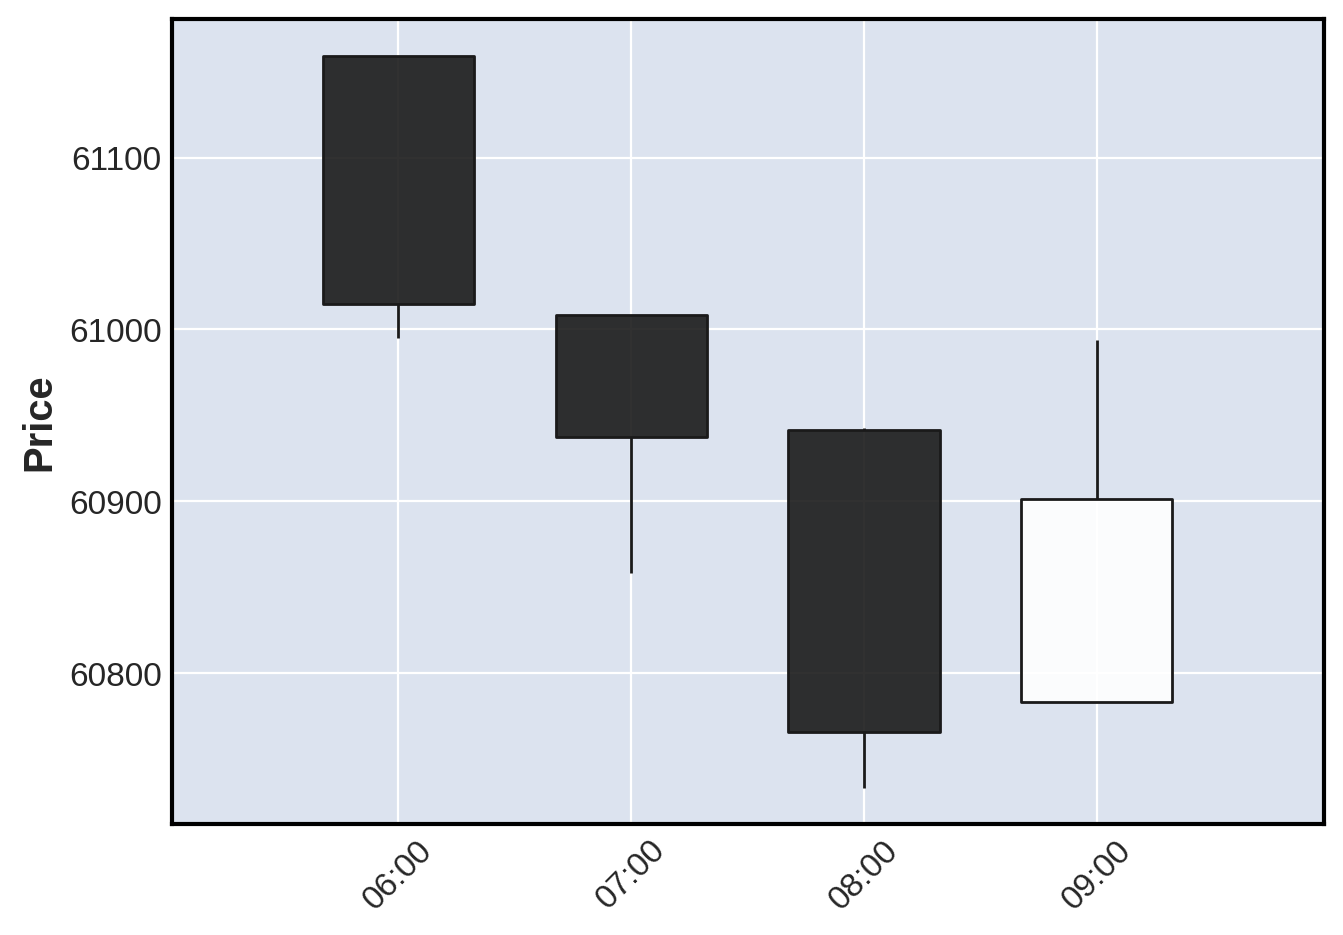

In [67]:
mpf.plot(df["2024-08-20 06:00:00":"2024-08-20 09:00:00"], 
         type="candle")

5. Locate and plot the bullish pattern:

In [68]:
df[df["3_line_strike"] == 100].head().round(2)

Open      High       Low     Close  Adj Close  \
2024-01-05 14:00:00+00:00  44031.47  44051.96  43353.72  43549.23   43549.23   
2024-01-25 20:00:00+00:00  39962.18  39980.28  39636.14  39636.14   39636.14   
2024-02-01 09:00:00+00:00  42199.54  42207.54  42104.32  42104.32   42104.32   
2024-03-08 21:00:00+00:00  69280.91  69310.95  68148.60  68384.72   68384.72   
2024-03-12 14:00:00+00:00  72286.52  72825.66  71726.44  71739.73   71739.73   

                               Volume  3_line_strike  
2024-01-05 14:00:00+00:00   485740544            100  
2024-01-25 20:00:00+00:00           0            100  
2024-02-01 09:00:00+00:00           0            100  
2024-03-08 21:00:00+00:00   566198272            100  
2024-03-12 14:00:00+00:00  1324093440            100

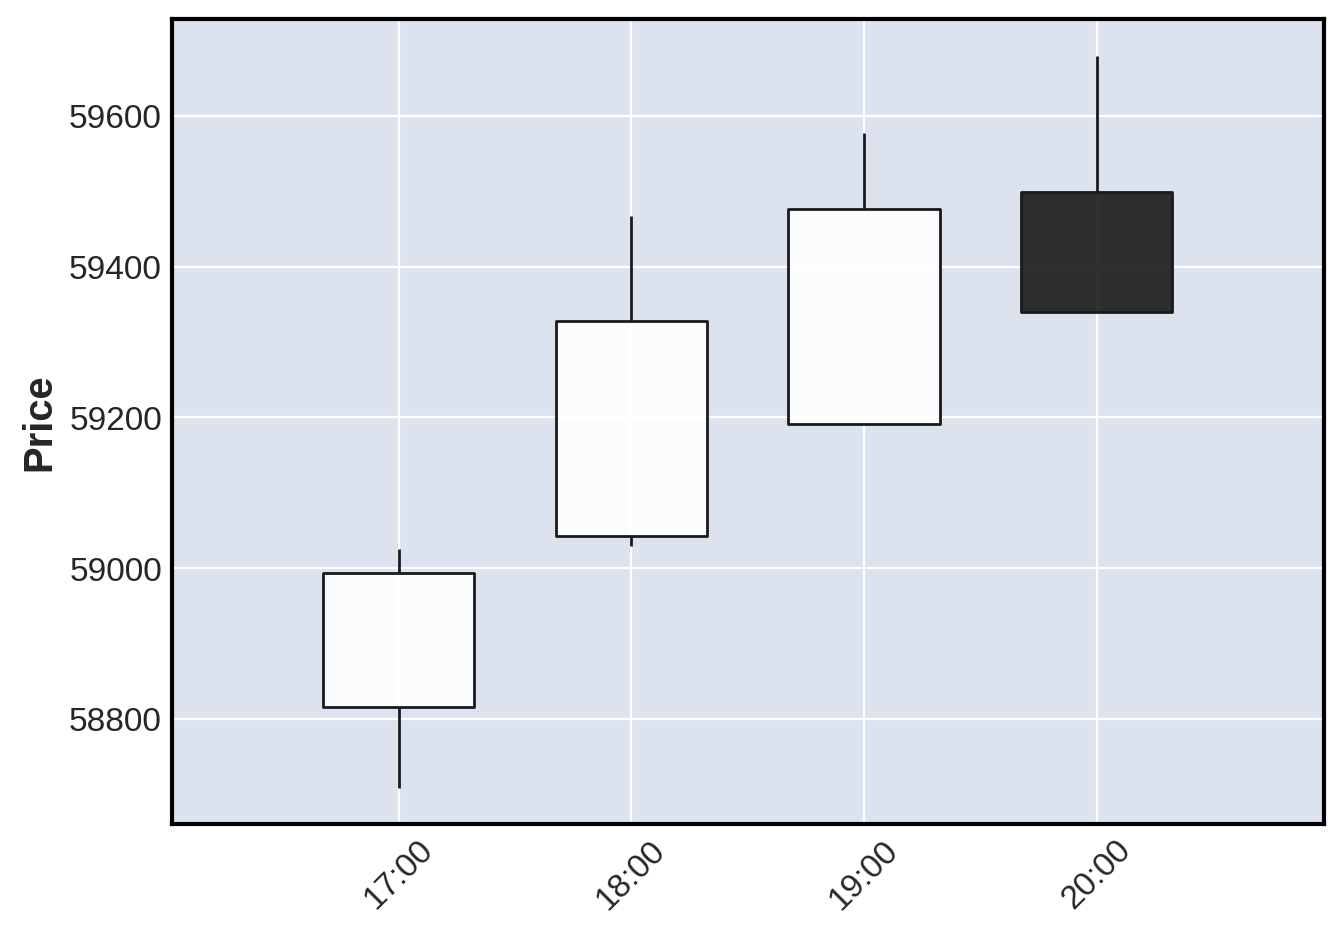

In [69]:
mpf.plot(df["2024-08-20 17:00:00":"2024-08-20 20:00:00"], 
         type="candle")

### There's more

식별된 패턴을 모델이나 전략의 특징으로 사용하고자 한다면, 가능한 모든 패턴을 한 번에 식별하는 것이 유용할 수 있습니다. 이를 실행하기 위해 다음 단계를 수행할 수 있습니다:

1. Get all available pattern names:

In [70]:
candle_names = talib.get_function_groups()["Pattern Recognition"]

2. Iterate over the list of patterns and try identifying them all:

In [71]:
for candle in candle_names:
    print(candle)
    df[candle] = getattr(talib, candle)(df["Open"], df["High"], 
                                        df["Low"], df["Close"])

CDL2CROWS
CDL3BLACKCROWS
CDL3INSIDE
CDL3LINESTRIKE
CDL3OUTSIDE
CDL3STARSINSOUTH
CDL3WHITESOLDIERS
CDLABANDONEDBABY
CDLADVANCEBLOCK
CDLBELTHOLD
CDLBREAKAWAY
CDLCLOSINGMARUBOZU
CDLCONCEALBABYSWALL
CDLCOUNTERATTACK
CDLDARKCLOUDCOVER
CDLDOJI
CDLDOJISTAR
CDLDRAGONFLYDOJI
CDLENGULFING
CDLEVENINGDOJISTAR
CDLEVENINGSTAR
CDLGAPSIDESIDEWHITE
CDLGRAVESTONEDOJI
CDLHAMMER
CDLHANGINGMAN
CDLHARAMI
CDLHARAMICROSS
CDLHIGHWAVE
CDLHIKKAKE
CDLHIKKAKEMOD
CDLHOMINGPIGEON
CDLIDENTICAL3CROWS
CDLINNECK
CDLINVERTEDHAMMER
CDLKICKING
CDLKICKINGBYLENGTH
CDLLADDERBOTTOM
CDLLONGLEGGEDDOJI
CDLLONGLINE
CDLMARUBOZU
CDLMATCHINGLOW
CDLMATHOLD
CDLMORNINGDOJISTAR
CDLMORNINGSTAR
CDLONNECK
CDLPIERCING
CDLRICKSHAWMAN
CDLRISEFALL3METHODS
CDLSEPARATINGLINES
CDLSHOOTINGSTAR
CDLSHORTLINE
CDLSPINNINGTOP
CDLSTALLEDPATTERN
CDLSTICKSANDWICH
CDLTAKURI
CDLTASUKIGAP
CDLTHRUSTING
CDLTRISTAR
CDLUNIQUE3RIVER
CDLUPSIDEGAP2CROWS
CDLXSIDEGAP3METHODS


3. Inspect the summary statistics of the patterns:

In [72]:
with pd.option_context("display.max_rows", len(candle_names)):
    display(df[candle_names].describe().transpose().round(2))

count   mean    std    min  25%  50%  75%    max
CDL2CROWS            6602.0  -0.05   2.13 -100.0  0.0  0.0  0.0    0.0
CDL3BLACKCROWS       6602.0  -0.05   2.13 -100.0  0.0  0.0  0.0    0.0
CDL3INSIDE           6602.0   0.29  11.48 -100.0  0.0  0.0  0.0  100.0
CDL3LINESTRIKE       6602.0   0.06   6.96 -100.0  0.0  0.0  0.0  100.0
CDL3OUTSIDE          6602.0   0.18  23.55 -100.0  0.0  0.0  0.0  100.0
CDL3STARSINSOUTH     6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDL3WHITESOLDIERS    6602.0   0.17   4.08    0.0  0.0  0.0  0.0  100.0
CDLABANDONEDBABY     6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDLADVANCEBLOCK      6602.0  -1.03  10.10 -100.0  0.0  0.0  0.0    0.0
CDLBELTHOLD          6602.0   0.70  43.58 -100.0  0.0  0.0  0.0  100.0
CDLBREAKAWAY         6602.0   0.02   1.23    0.0  0.0  0.0  0.0  100.0
CDLCLOSINGMARUBOZU   6602.0   1.47  40.22 -100.0  0.0  0.0  0.0  100.0
CDLCONCEALBABYSWALL  6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDLCOUNTERATTACK     6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDLDARKCLOUDCOVER    6602.0  -0.48   6.95 -100.0  0.0  0.0  0.0    0.0
CDLDOJI              6602.0  13.51  34.19    0.0  0.0  0.0  0.0  100.0
CDLDOJISTAR          6602.0  -0.15  12.67 -100.0  0.0  0.0  0.0  100.0
CDLDRAGONFLYDOJI     6602.0   2.65  16.06    0.0  0.0  0.0  0.0  100.0
CDLENGULFING         6602.0   0.23  34.28 -100.0  0.0  0.0  0.0  100.0
CDLEVENINGDOJISTAR   6602.0  -0.11   3.25 -100.0  0.0  0.0  0.0    0.0
CDLEVENINGSTAR       6602.0  -0.41   6.38 -100.0  0.0  0.0  0.0    0.0
CDLGAPSIDESIDEWHITE  6602.0   0.20   5.07 -100.0  0.0  0.0  0.0  100.0
CDLGRAVESTONEDOJI    6602.0   2.89  16.76    0.0  0.0  0.0  0.0  100.0
CDLHAMMER            6602.0   4.04  19.70    0.0  0.0  0.0  0.0  100.0
CDLHANGINGMAN        6602.0  -2.26  14.85 -100.0  0.0  0.0  0.0    0.0
CDLHARAMI            6602.0  -0.50  25.49 -100.0  0.0  0.0  0.0  100.0
CDLHARAMICROSS       6602.0  -0.33  12.43 -100.0  0.0  0.0  0.0  100.0
CDLHIGHWAVE          6602.0   0.12  30.84 -100.0  0.0  0.0  0.0  100.0
CDLHIKKAKE           6602.0   1.95  50.28 -200.0  0.0  0.0  0.0  200.0
CDLHIKKAKEMOD        6602.0  -0.02   7.49 -200.0  0.0  0.0  0.0  200.0
CDLHOMINGPIGEON      6602.0   0.30   5.50    0.0  0.0  0.0  0.0  100.0
CDLIDENTICAL3CROWS   6602.0  -0.23   4.76 -100.0  0.0  0.0  0.0    0.0
CDLINNECK            6602.0  -0.05   2.13 -100.0  0.0  0.0  0.0    0.0
CDLINVERTEDHAMMER    6602.0   1.32  11.40    0.0  0.0  0.0  0.0  100.0
CDLKICKING           6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDLKICKINGBYLENGTH   6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDLLADDERBOTTOM      6602.0   0.02   1.23    0.0  0.0  0.0  0.0  100.0
CDLLONGLEGGEDDOJI    6602.0  13.41  34.07    0.0  0.0  0.0  0.0  100.0
CDLLONGLINE          6602.0   1.15  41.80 -100.0  0.0  0.0  0.0  100.0
CDLMARUBOZU          6602.0   0.47  27.32 -100.0  0.0  0.0  0.0  100.0
CDLMATCHINGLOW       6602.0   1.27  11.21    0.0  0.0  0.0  0.0  100.0
CDLMATHOLD           6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDLMORNINGDOJISTAR   6602.0   0.11   3.25    0.0  0.0  0.0  0.0  100.0
CDLMORNINGSTAR       6602.0   0.47   6.84    0.0  0.0  0.0  0.0  100.0
CDLONNECK            6602.0  -0.14   3.69 -100.0  0.0  0.0  0.0    0.0
CDLPIERCING          6602.0   0.38   6.14    0.0  0.0  0.0  0.0  100.0
CDLRICKSHAWMAN       6602.0   8.42  27.77    0.0  0.0  0.0  0.0  100.0
CDLRISEFALL3METHODS  6602.0   0.00   0.00    0.0  0.0  0.0  0.0    0.0
CDLSEPARATINGLINES   6602.0  -0.08   8.44 -100.0  0.0  0.0  0.0  100.0
CDLSHOOTINGSTAR      6602.0  -1.26  11.14 -100.0  0.0  0.0  0.0    0.0
CDLSHORTLINE         6602.0   0.17  42.80 -100.0  0.0  0.0  0.0  100.0
CDLSPINNINGTOP       6602.0  -0.05  40.05 -100.0  0.0  0.0  0.0  100.0
CDLSTALLEDPATTERN    6602.0  -0.33   5.76 -100.0  0.0  0.0  0.0    0.0
CDLSTICKSANDWICH     6602.0   0.11   3.25    0.0  0.0  0.0  0.0  100.0
CDLTAKURI            6602.0   2.54  15.75    0.0  0.0  0.0  0.0  100.0
CDLTASUKIGAP         6602.0  -0.02   5.07 -100

4. Locate and plot the "Evening Star" pattern:

In [73]:
df[df["CDLEVENINGSTAR"]  == -100].head()

Open          High           Low  \
2023-12-02 22:00:00+00:00  39581.941406  39600.855469  39334.484375   
2023-12-20 19:00:00+00:00  44172.429688  44259.953125  43811.957031   
2023-12-27 00:00:00+00:00  42518.468750  42532.941406  42369.894531   
2024-01-25 01:00:00+00:00  40153.394531  40153.394531  39938.117188   
2024-02-02 17:00:00+00:00  43214.003906  43267.878906  42924.406250   

                                  Close     Adj Close     Volume  \
2023-12-02 22:00:00+00:00  39361.500000  39361.500000  374515712   
2023-12-20 19:00:00+00:00  43811.957031  43811.957031  605323264   
2023-12-27 00:00:00+00:00  42369.894531  42369.894531   41416704   
2024-01-25 01:00:00+00:00  39982.304688  39982.304688          0   
2024-02-02 17:00:00+00:00  42924.406250  42924.406250          0   

                           3_line_strike  CDL2CROWS  CDL3BLACKCROWS  \
2023-12-02 22:00:00+00:00              0          0               0   
2023-12-20 19:00:00+00:00              0          0               0   
2023-12-27 00:00:00+00:00              0          0               0   
2024-01-25 01:00:00+00:00              0          0               0   
2024-02-02 17:00:00+00:00              0          0               0   

                           CDL3INSIDE  ...  CDLSPINNINGTOP  CDLSTALLEDPATTERN  \
2023-12-02 22:00:00+00:00           0  ...               0                  0   
2023-12-20 19:00:00+00:00           0  ...               0                  0   
2023-12-27 00:00:00+00:00           0  ...               0                  0   
2024-01-25 01:00:00+00:00           0  ...               0                  0   
2024-02-02 17:00:00+00:00           0  ...               0                  0   

                           CDLSTICKSANDWICH  CDLTAKURI  CDLTASUKIGAP  \
2023-12-02 22:00:00+00:00                 0          0             0   
2023-12-20 19:00:00+00:00                 0          0             0   
2023-12-27 00:00:00+00:00                 0          0             0   
2024-01-25 01:00:00+00:00                 0          0             0   
2024-02-02 17:00:00+00:00                 0          0             0   

                           CDLTHRUSTING  CDLTRISTAR  CDLUNIQUE3RIVER  \
2023-12-02 22:00:00+00:00             0           0                0   
2023-12-20 19:00:00+00:00             0           0                0   
2023-12-27 00:00:00+00:00             0           0                0   
2024-01-25 01:00:00+00:00             0           0                0   
2024-02-02 17:00:00+00:00             0           0                0   

                           CDLUPSIDEGAP2CROWS  CDLXSIDEGAP3METHODS  
2023-12-02 22:00:00+00:00                   0                    0  
2023-12-20 19:00:00+00:00                   0                  100  
2023-12-27 00:00:00+00:00                   0                    0  
2024-01-25 01:00:00+00:00                   0                    0  
2024-02-02 17:00:00+00:00                   0                    0  

[5 rows x 68 columns]

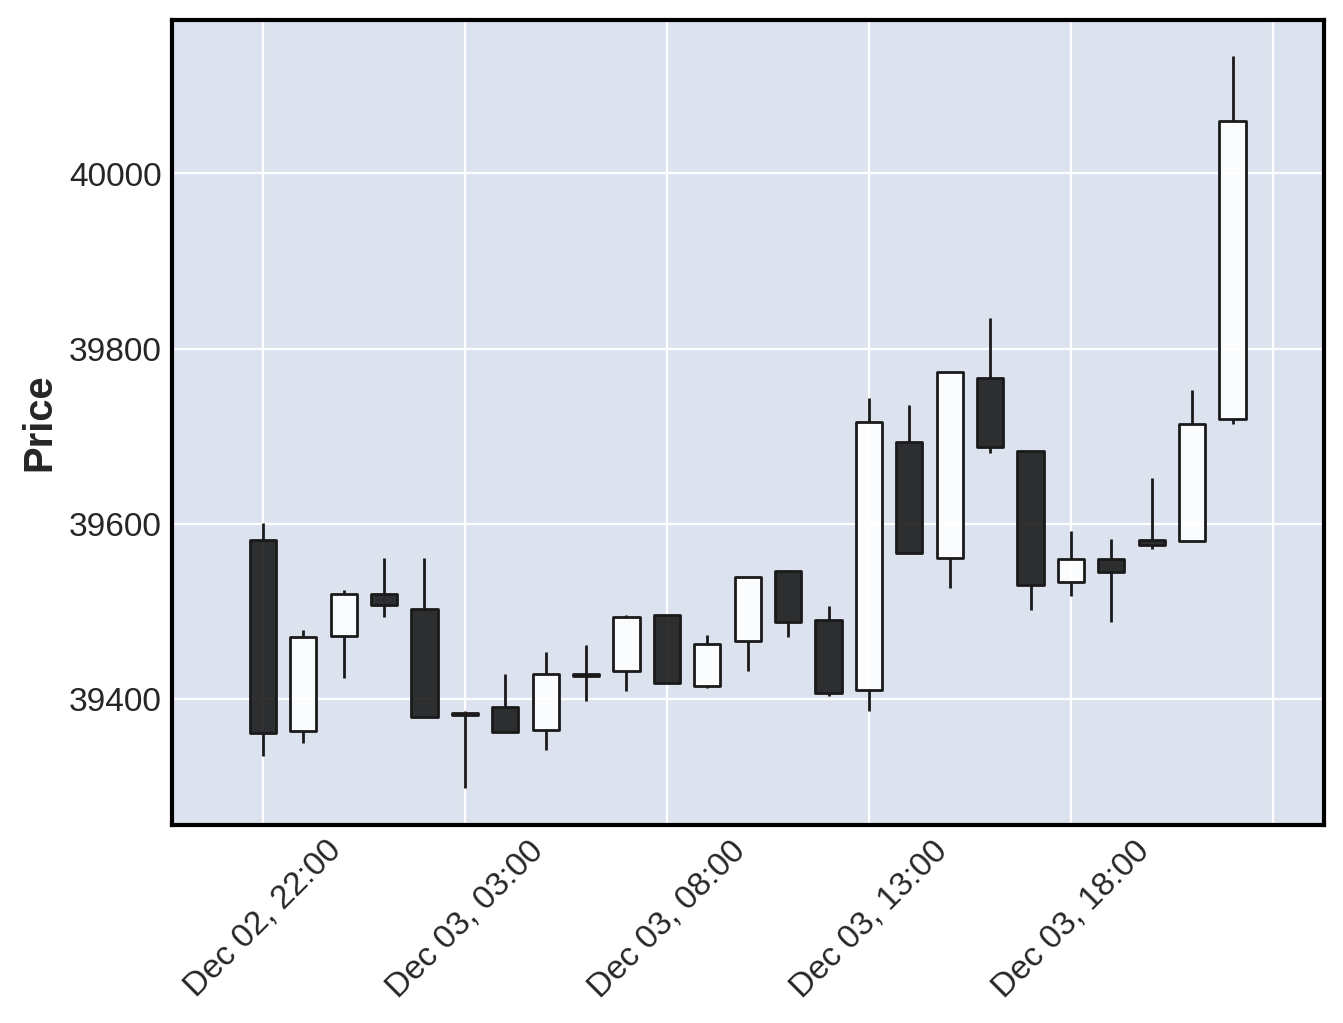

In [75]:
mpf.plot(df["2023-12-02 22:00:00":"2023-12-03 22:00:00"], type="candle")

## 5.4 Building an interactive web app for technical analysis using Streamlit

이 장에서는 트레이더들이 의사 결정을 내리는 데 도움을 주는 기술적 분석의 기초를 다루었습니다. 그러나 지금까지의 과정은 다소 정적이었습니다. 데이터를 다운로드하고, 지표를 계산하고, 이를 플로팅했습니다. 자산이나 날짜 범위를 변경하려면 모든 단계를 반복해야 했습니다. 이러한 문제를 더 나은 방식으로, 더 상호작용적으로 접근할 수 있다면 어떨까요? 바로 여기서 Streamlit이 등장합니다. Streamlit은 오픈 소스 프레임워크로, Plotly와 마찬가지로 동일한 이름의 회사이기도 하며, Python만 사용하여 몇 분 안에 상호작용 웹 앱을 구축할 수 있게 해줍니다.

- Streamlit의 주요 특징
    - **사용 용이성**: Streamlit은 배우기 쉽고, 슬라이더, 버튼, 플롯과 같은 상호작용 요소를 친숙한 Python 구문으로 생성할 수 있습니다.
    - **빠른 개발**: Streamlit을 사용하면 웹 앱을 빠르게 구축하고 배포할 수 있어 데이터 탐색 및 시각화 작업에 이상적입니다.
    - **Python 전용**: HTML, CSS, JavaScript가 필요 없으므로 데이터 및 머신러닝 측면에 집중할 수 있습니다.
    - **호스팅 서비스**: Streamlit은 호스팅 서비스를 제공하여 배포 과정을 간소화합니다.

- 상호작용 기술 분석 앱 구축
    - Streamlit을 사용하여 S&P 500 구성 요소의 기술 분석을 위한 상호작용 앱을 개발할 수 있습니다. 이 앱은 사용자가 주식을 선택하고 빠르고 상호작용적인 분석을 수행할 수 있도록 합니다. 또한, 다양한 지표, 자산 또는 거래 전략의 백테스팅을 포함하도록 쉽게 확장할 수 있습니다.
    - Streamlit의 기능은 데이터 과학 및 금융 분야에서 동적이고 사용자 친화적인 애플리케이션을 만드는 데 탁월한 선택이 되며, 트레이더와 분석가가 데이터를 실시간으로 상호작용하고 더 나은 결정을 내릴 수 있도록 도와줍니다.

### Getting ready

- 이 레시피는 다른 것들과 약간 다릅니다. 
    - 우리의 앱 코드는 하나의 Python 스크립트(technical_analysis_app.py)에 있으며, 약 100줄의 코드로 구성되어 있습니다. 
    - 매우 기본적인 앱은 더 간결할 수 있지만, 우리는 Streamlit의 가장 흥미로운 기능들을 살펴보고자 했습니다. 
    - 이러한 기능들은 기본적인 기술 분석 앱을 만드는 데 꼭 필요하지는 않지만 유용합니다. 
    - 일반적으로 Streamlit은 코드를 위에서 아래로 실행하므로, 이 책에서 사용된 구조에 맞춰 설명하기가 더 쉽습니다. 따라서 이 레시피의 단계들은 독립적으로 실행할 수 있는 단계가 아닙니다. 대신, 앱의 모든 구성 요소를 단계별로 안내하는 것입니다. 
    - 여러분이 자신의 앱을 만들거나 이 앱을 확장할 때, Streamlit의 프레임워크에 맞추어 단계의 순서를 자유롭게 변경할 수 있습니다.

## 5.5 Building an Interactive Dashboard for Technical Analysis

- 책의 첫 번째 판에서는 Jupyter Notebook 내에서 기술 분석 대시보드를 구축하는 예제를 다루었습니다.
- 이를 위해 `ipywidgets` 라이브러리와 `cufflinks`의 상호작용 플로팅 기능을 사용했습니다.
- 두 번째 판에서는 매우 유사한 대시보드를 구축하기 위해 Streamlit을 사용했습니다.
- 하지만 이전 접근 방식도 여전히 유용할 수 있으며, 다른 종류의 분석에 유용할 수 있습니다.

### How to do it...

1. Import the libraries:

In [98]:
import ipywidgets as wd
from ipywidgets import interact, interact_manual
import cufflinks as cf
import pandas as pd 
import yfinance as yf
from plotly.offline import iplot, init_notebook_mode

cf.go_offline()
init_notebook_mode()

2. Define the possible values for assets and technical indicators:

In [99]:
stocks = ["X", "MSFT", "GOOGL", "META", "TSLA", "AAPL"]
indicators = ["Bollinger Bands", "MACD", "RSI"]

3. Define a function for creating the interactive plot:

In [109]:
def ta_dashboard(asset, indicator, start_date, end_date, 
                 bb_k, bb_n, macd_fast, macd_slow, macd_signal,
                 rsi_periods, rsi_upper, rsi_lower):
    
    # 주어진 자산의 주식 데이터를 다운로드
    df = yf.download(asset, 
                     start=start_date, 
                     end=end_date,
                     progress=False,
                     auto_adjust=True)

    # QuantFig 객체 생성, 대시보드 제목 및 범례 위치 설정
    qf = cf.QuantFig(df, title=f"TA Dashboard - {asset}", 
                     legend="right", name=f"{asset}")
            
    # 볼린저 밴드 지표 추가
    if "Bollinger Bands" in indicator: 
        qf.add_bollinger_bands(periods=bb_n, 
                               boll_std=bb_k)
    # MACD 지표 추가
    if "MACD" in indicator: 
        qf.add_macd(fast_period=macd_fast, 
                    slow_period=macd_slow, 
                    signal_period=macd_signal)
    # RSI 지표 추가
    if "RSI" in indicator: 
        qf.add_rsi(periods=rsi_periods, 
                   rsi_upper=rsi_upper, 
                   rsi_lower=rsi_lower, 
                   showbands=True)

    # 플롯을 반환
    return qf.iplot()

4. Define the selectors:

In [101]:
# 주식 선택을 위한 드롭다운 위젯 생성
stocks_selector = wd.Dropdown(
    options=stocks,  # 선택 가능한 주식 목록
    value=stocks[0],  # 기본 선택값으로 첫 번째 주식 설정
    description="Asset"  # 위젯 설명
)

# 지표 선택을 위한 다중 선택 위젯 생성
indicator_selector = wd.SelectMultiple(
    description="Indicator",  # 위젯 설명
    options=indicators,  # 선택 가능한 지표 목록
    value=[indicators[0]]  # 기본 선택값으로 첫 번째 지표 설정
)

# 시작 날짜 선택을 위한 날짜 선택 위젯 생성
start_date_selector = wd.DatePicker(
    description="Start Date",  # 위젯 설명
    value=pd.to_datetime("2018-01-01"),  # 기본 시작 날짜 설정
    continuous_update=False  # 날짜 선택 시 실시간 업데이트 비활성화
)

# 종료 날짜 선택을 위한 날짜 선택 위젯 생성
end_date_selector = wd.DatePicker(
    description="End Date",  # 위젯 설명
    value=pd.to_datetime("2018-12-31"),  # 기본 종료 날짜 설정
    continuous_update=False  # 날짜 선택 시 실시간 업데이트 비활성화
)

5. Define a label and group the selectors inside a container:

In [110]:
# 메인 매개변수에 대한 레이블 위젯 생성
main_selector_label = wd.Label(
    "Main parameters",  # 레이블 텍스트
    layout=wd.Layout(height="45px")  # 레이블 높이 설정
)

# 메인 매개변수 선택을 위한 수직 박스 레이아웃 생성
main_selector_box = wd.VBox(
    children=[  # 수직 박스에 포함될 자식 위젯들
        main_selector_label,  # 메인 매개변수 레이블
        stocks_selector,  # 주식 선택 드롭다운
        indicator_selector,  # 지표 선택 다중 선택 위젯
        start_date_selector,  # 시작 날짜 선택 위젯
        end_date_selector  # 종료 날짜 선택 위젯
    ]
)

6. Define the secondary selectors for Bollinger Bands:

In [111]:
# 볼린저 밴드를 위한 레이블 위젯 생성
bb_label = wd.Label("Bollinger Bands")

# 볼린저 밴드의 N 파라미터를 위한 정수 슬라이더 위젯 생성
n_param = wd.IntSlider(
    value=20,  # 기본값 설정
    min=1,  # 최소값 설정
    max=40,  # 최대값 설정
    step=1,  # 증가 단위 설정
    description="N:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# 볼린저 밴드의 k 파라미터를 위한 부동 소수점 슬라이더 위젯 생성
k_param = wd.FloatSlider(
    value=2,  # 기본값 설정
    min=0.5,  # 최소값 설정
    max=4,  # 최대값 설정
    step=0.5,  # 증가 단위 설정
    description="k:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# 볼린저 밴드 설정을 위한 수직 박스 레이아웃 생성
bollinger_box = wd.VBox(
    children=[bb_label, n_param, k_param]  # 수직 박스에 포함될 자식 위젯들
)

7. Define the secondary selectors for MACD:

In [112]:
# MACD를 위한 레이블 위젯 생성
macd_label = wd.Label("MACD")

# MACD의 빠른 평균을 위한 정수 슬라이더 위젯 생성
macd_fast = wd.IntSlider(
    value=12,  # 기본값 설정
    min=2,  # 최소값 설정
    max=50,  # 최대값 설정
    step=1,  # 증가 단위 설정
    description="Fast avg:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# MACD의 느린 평균을 위한 정수 슬라이더 위젯 생성
macd_slow = wd.IntSlider(
    value=26,  # 기본값 설정
    min=2,  # 최소값 설정
    max=50,  # 최대값 설정
    step=1,  # 증가 단위 설정
    description="Slow avg:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# MACD 신호를 위한 정수 슬라이더 위젯 생성
macd_signal = wd.IntSlider(
    value=9,  # 기본값 설정
    min=2,  # 최소값 설정
    max=50,  # 최대값 설정
    step=1,  # 증가 단위 설정
    description="MACD signal:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# MACD 설정을 위한 수직 박스 레이아웃 생성
macd_box = wd.VBox(
    children=[macd_label, macd_fast, macd_slow, macd_signal]  # 수직 박스에 포함될 자식 위젯들
)

8. Define the secondary selectors for RSI:

In [113]:
# RSI를 위한 레이블 위젯 생성
rsi_label = wd.Label("RSI")

# RSI 기간을 위한 정수 슬라이더 위젯 생성
rsi_periods = wd.IntSlider(
    value=14,  # 기본값 설정
    min=2,  # 최소값 설정
    max=50,  # 최대값 설정
    step=1,  # 증가 단위 설정
    description="RSI periods:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# RSI 상한 임계값을 위한 정수 슬라이더 위젯 생성
rsi_upper = wd.IntSlider(
    value=70,  # 기본값 설정
    min=1,  # 최소값 설정
    max=100,  # 최대값 설정
    step=1,  # 증가 단위 설정
    description="Upper Thr:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# RSI 하한 임계값을 위한 정수 슬라이더 위젯 생성
rsi_lower = wd.IntSlider(
    value=30,  # 기본값 설정
    min=1,  # 최소값 설정
    max=100,  # 최대값 설정
    step=1,  # 증가 단위 설정
    description="Lower Thr:",  # 슬라이더 설명
    continuous_update=False  # 슬라이더 이동 시 실시간 업데이트 비활성화
)

# RSI 설정을 위한 수직 박스 레이아웃 생성
rsi_box = wd.VBox(
    children=[rsi_label, rsi_periods, rsi_upper, rsi_lower]  # 수직 박스에 포함될 자식 위젯들
)

9. Create the labels and group the selectors into containers:

In [114]:
# 보조 매개변수에 대한 레이블 위젯 생성
sec_selector_label = wd.Label(
    "Secondary parameters",  # 레이블 텍스트
    layout=wd.Layout(height="45px")  # 레이블 높이 설정
)

# 빈 레이블 위젯 생성 (레이아웃 조정을 위해 사용)
blank_label = wd.Label(
    "",  # 빈 텍스트
    layout=wd.Layout(height="45px")  # 레이블 높이 설정
)

# 첫 번째 수직 박스 레이아웃 생성, 보조 매개변수 레이블과 볼린저 밴드, MACD 설정 포함
sec_box_1 = wd.VBox(
    [sec_selector_label, bollinger_box, macd_box]  # 수직 박스에 포함될 자식 위젯들
)

# 두 번째 수직 박스 레이아웃 생성, 빈 레이블과 RSI 설정 포함
sec_box_2 = wd.VBox(
    [blank_label, rsi_box]  # 수직 박스에 포함될 자식 위젯들
)

# 두 개의 수직 박스를 수평으로 정렬하는 수평 박스 레이아웃 생성
secondary_selector_box = wd.HBox(
    [sec_box_1, sec_box_2]  # 수평 박스에 포함될 자식 위젯들
)

10. Group the boxes and prepare the interactive output:

In [115]:
# 위젯과 매개변수를 매핑하는 딕셔너리 생성
controls_dict = {
    "asset": stocks_selector,  # 자산 선택 위젯
    "indicator": indicator_selector,  # 지표 선택 위젯
    "start_date": start_date_selector,  # 시작 날짜 선택 위젯
    "end_date": end_date_selector,  # 종료 날짜 선택 위젯
    "bb_k": k_param,  # 볼린저 밴드 k 파라미터 슬라이더
    "bb_n": n_param,  # 볼린저 밴드 N 파라미터 슬라이더
    "macd_fast": macd_fast,  # MACD 빠른 평균 슬라이더
    "macd_slow": macd_slow,  # MACD 느린 평균 슬라이더
    "macd_signal": macd_signal,  # MACD 신호 슬라이더
    "rsi_periods": rsi_periods,  # RSI 기간 슬라이더
    "rsi_upper": rsi_upper,  # RSI 상한 임계값 슬라이더
    "rsi_lower": rsi_lower  # RSI 하한 임계값 슬라이더
}

# 메인 선택 박스와 보조 선택 박스를 수평으로 정렬하는 UI 레이아웃 생성
ui = wd.HBox([main_selector_box, secondary_selector_box])

# 대시보드 함수와 위젯을 연결하여 상호작용 출력 생성
out = wd.interactive_output(ta_dashboard, controls_dict)

11. Display the dashboard:

In [116]:
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'application/vnd.plotly.v1+json': {'data': [{'legendg…